## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp028'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.9),
        A.RandomBrightnessContrast(p=0.9),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.9),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.9),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

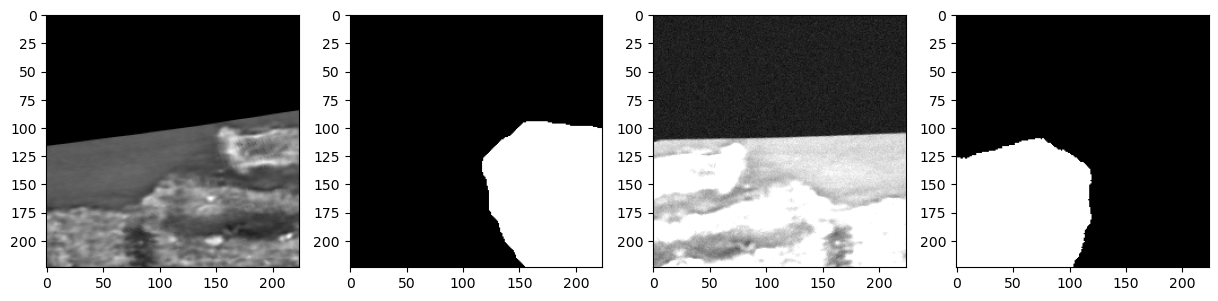

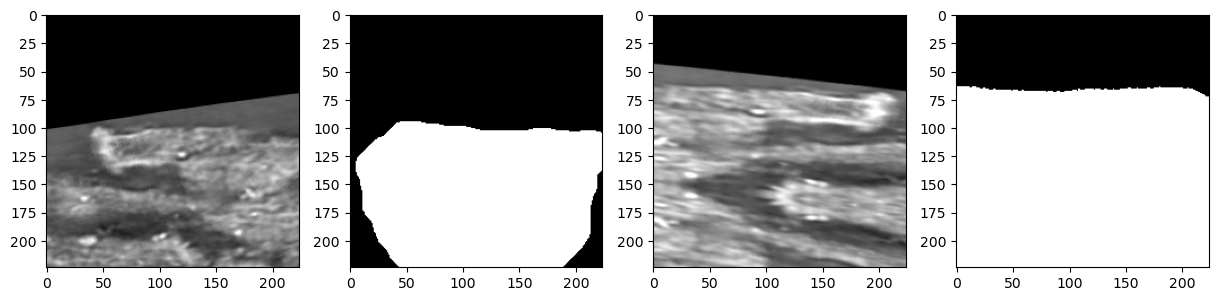

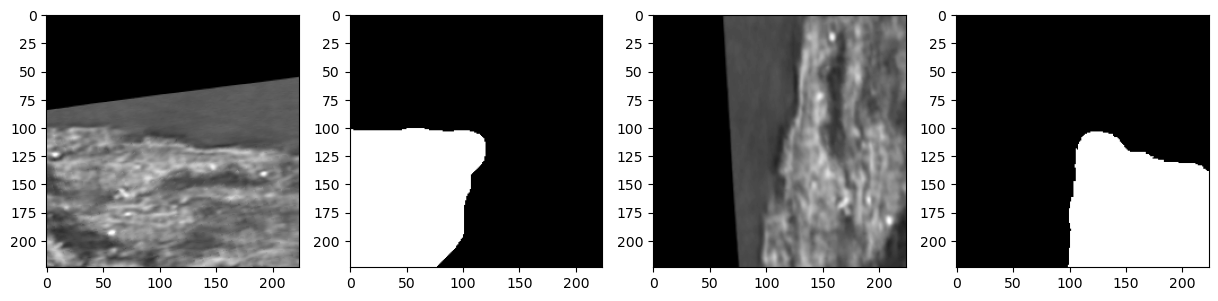

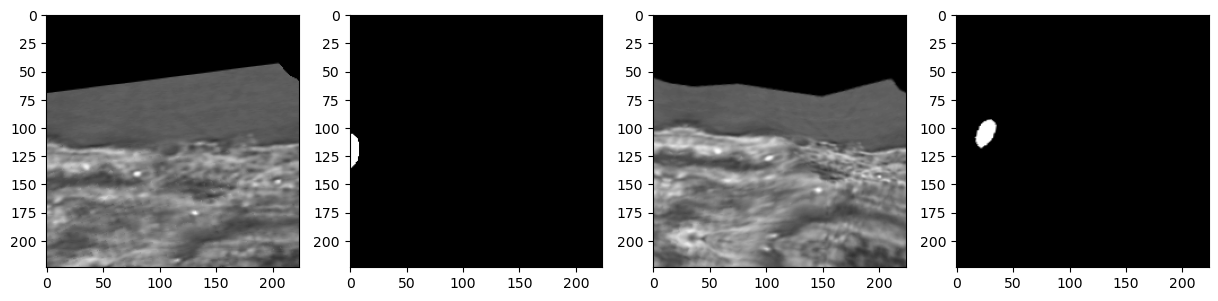

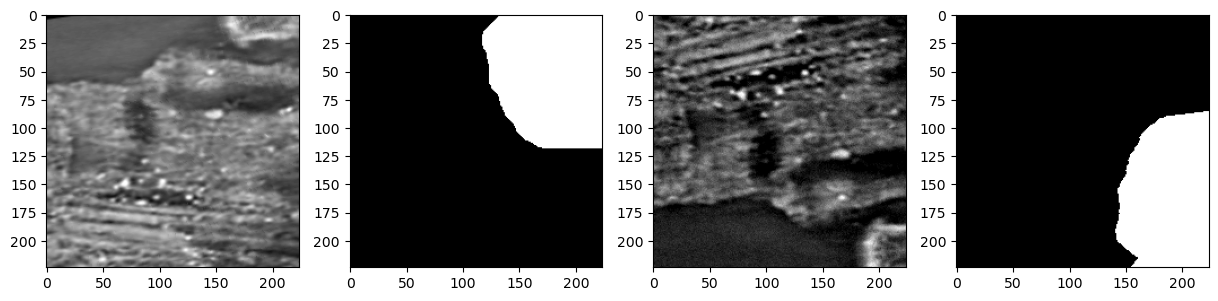

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48124

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.14207997193864505
th: 0.15, fbeta: 0.1420221183712711
th: 0.2, fbeta: 0.14176254933952084
th: 0.25, fbeta: 0.14118499736067333
th: 0.3, fbeta: 0.1966446106396134
th: 0.35, fbeta: 0.21240212261239974
th: 0.4, fbeta: 0.22423738747085303
th: 0.45, fbeta: 0.2285179258680268


best_th: 0.45, fbeta: 0.2285179258680268
Epoch 1 - avg_train_loss: 0.6733  avg_val_loss: 0.5122  time: 124s
Epoch 1 - avgScore: 0.2285
Epoch 1 - Save Best Score: 0.2285 Model
Epoch 1 - Save Best Loss: 0.5122 Model


th: 0.5, fbeta: 0.22571255312276015


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14209197344070834
th: 0.15, fbeta: 0.1420747113793459
th: 0.2, fbeta: 0.14461213645887935
th: 0.25, fbeta: 0.2164347072949438
th: 0.3, fbeta: 0.24636309543677956
th: 0.35, fbeta: 0.2668011252910559
th: 0.4, fbeta: 0.22781898311668167
th: 0.45, fbeta: 0.16414922217572728


best_th: 0.35, fbeta: 0.2668011252910559
Epoch 2 - avg_train_loss: 0.4528  avg_val_loss: 0.4097  time: 127s
Epoch 2 - avgScore: 0.2668
Epoch 2 - Save Best Score: 0.2668 Model
Epoch 2 - Save Best Loss: 0.4097 Model


th: 0.5, fbeta: 0.10536112074762644


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.24456537799917874
th: 0.15, fbeta: 0.3047532099060905
th: 0.2, fbeta: 0.3049380434860156
th: 0.25, fbeta: 0.2796673250539335
th: 0.3, fbeta: 0.24793261225623198
th: 0.35, fbeta: 0.21490201083547264
th: 0.4, fbeta: 0.17720619346259348
th: 0.45, fbeta: 0.13848213638339515


best_th: 0.2, fbeta: 0.3049380434860156
Epoch 3 - avg_train_loss: 0.3000  avg_val_loss: 0.3326  time: 126s
Epoch 3 - avgScore: 0.3049
Epoch 3 - Save Best Score: 0.3049 Model
Epoch 3 - Save Best Loss: 0.3326 Model


th: 0.5, fbeta: 0.10234752339258116


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34094694829462535
th: 0.15, fbeta: 0.3088535421392017
th: 0.2, fbeta: 0.23213183778853644
th: 0.25, fbeta: 0.16545722769740798
th: 0.3, fbeta: 0.11813592381344816
th: 0.35, fbeta: 0.08219742467403265
th: 0.4, fbeta: 0.05491974524207692
th: 0.45, fbeta: 0.03611228879650557


best_th: 0.1, fbeta: 0.34094694829462535
Epoch 4 - avg_train_loss: 0.2235  avg_val_loss: 0.3597  time: 127s
Epoch 4 - avgScore: 0.3409
Epoch 4 - Save Best Score: 0.3409 Model
Epoch 4 - Save Best Loss: 0.3597 Model


th: 0.5, fbeta: 0.022656386019153422


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35533086420059484
th: 0.15, fbeta: 0.36248661379262853
th: 0.2, fbeta: 0.34199649233851565
th: 0.25, fbeta: 0.3126671749690146
th: 0.3, fbeta: 0.28261470719193627
th: 0.35, fbeta: 0.24901678321617715
th: 0.4, fbeta: 0.21295563785629187
th: 0.45, fbeta: 0.17934881326040103


best_th: 0.15, fbeta: 0.36248661379262853
Epoch 5 - avg_train_loss: 0.2095  avg_val_loss: 0.4350  time: 126s
Epoch 5 - avgScore: 0.3625
Epoch 5 - Save Best Score: 0.3625 Model
Epoch 5 - Save Best Loss: 0.4350 Model


th: 0.5, fbeta: 0.1494500957904196


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3660237729881617
th: 0.15, fbeta: 0.35885277660288006
th: 0.2, fbeta: 0.32731362381774737
th: 0.25, fbeta: 0.2862897029598544
th: 0.3, fbeta: 0.24614011010710563
th: 0.35, fbeta: 0.21056843529809838
th: 0.4, fbeta: 0.1761728902693069
th: 0.45, fbeta: 0.14447418713015864


best_th: 0.1, fbeta: 0.3660237729881617
Epoch 6 - avg_train_loss: 0.1999  avg_val_loss: 0.4504  time: 124s
Epoch 6 - avgScore: 0.3660
Epoch 6 - Save Best Score: 0.3660 Model
Epoch 6 - Save Best Loss: 0.4504 Model


th: 0.5, fbeta: 0.11798896894089068


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37832309991228263
th: 0.15, fbeta: 0.3688802703998442
th: 0.2, fbeta: 0.33837894718568823
th: 0.25, fbeta: 0.29002170583663095
th: 0.3, fbeta: 0.2397531749598669
th: 0.35, fbeta: 0.19299864291198343
th: 0.4, fbeta: 0.1511193758544433
th: 0.45, fbeta: 0.10917774471870417


best_th: 0.1, fbeta: 0.37832309991228263
Epoch 7 - avg_train_loss: 0.1907  avg_val_loss: 0.4427  time: 124s
Epoch 7 - avgScore: 0.3783
Epoch 7 - Save Best Score: 0.3783 Model
Epoch 7 - Save Best Loss: 0.4427 Model


th: 0.5, fbeta: 0.07305054418422735


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29434017736482543
th: 0.15, fbeta: 0.2400627244462983
th: 0.2, fbeta: 0.19819468534830204
th: 0.25, fbeta: 0.1641771219957814
th: 0.3, fbeta: 0.13555694043073294
th: 0.35, fbeta: 0.11416693387285447
th: 0.4, fbeta: 0.09277699596239612
th: 0.45, fbeta: 0.07424493872057619


best_th: 0.1, fbeta: 0.29434017736482543
Epoch 8 - avg_train_loss: 0.1835  avg_val_loss: 0.4766  time: 124s
Epoch 8 - avgScore: 0.2943


th: 0.5, fbeta: 0.059723196477812164


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35070942521886045
th: 0.15, fbeta: 0.28234353808378965
th: 0.2, fbeta: 0.22283963850626298
th: 0.25, fbeta: 0.17869746851615909
th: 0.3, fbeta: 0.14474711449413
th: 0.35, fbeta: 0.11324388986649225
th: 0.4, fbeta: 0.08726755680899641
th: 0.45, fbeta: 0.06666772811134952


best_th: 0.1, fbeta: 0.35070942521886045
Epoch 9 - avg_train_loss: 0.1745  avg_val_loss: 0.4499  time: 123s
Epoch 9 - avgScore: 0.3507


th: 0.5, fbeta: 0.05048882808248459


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35970381384408895
th: 0.15, fbeta: 0.3558659871059033
th: 0.2, fbeta: 0.34358501297172067
th: 0.25, fbeta: 0.3241732816101693
th: 0.3, fbeta: 0.30227580460369335
th: 0.35, fbeta: 0.2785968555974947
th: 0.4, fbeta: 0.2538130283086135
th: 0.45, fbeta: 0.2304939402444367


best_th: 0.1, fbeta: 0.35970381384408895
Epoch 10 - avg_train_loss: 0.1696  avg_val_loss: 0.4092  time: 124s
Epoch 10 - avgScore: 0.3597


th: 0.5, fbeta: 0.20696966430937339


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32987821002872975
th: 0.15, fbeta: 0.29576688450979544
th: 0.2, fbeta: 0.2604521641288212
th: 0.25, fbeta: 0.22565900786978332
th: 0.3, fbeta: 0.19004577093680197
th: 0.35, fbeta: 0.16082091288751427
th: 0.4, fbeta: 0.13565159025656057
th: 0.45, fbeta: 0.11071058384953732


best_th: 0.1, fbeta: 0.32987821002872975
Epoch 11 - avg_train_loss: 0.1594  avg_val_loss: 0.4441  time: 123s
Epoch 11 - avgScore: 0.3299


th: 0.5, fbeta: 0.08714221580470279


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2745451679247469
th: 0.15, fbeta: 0.22437391520659433
th: 0.2, fbeta: 0.18516440972001288
th: 0.25, fbeta: 0.15289653769156364
th: 0.3, fbeta: 0.12929850775199148
th: 0.35, fbeta: 0.10929745143335128
th: 0.4, fbeta: 0.08937594333322388
th: 0.45, fbeta: 0.07016907088024937


best_th: 0.1, fbeta: 0.2745451679247469
Epoch 12 - avg_train_loss: 0.1521  avg_val_loss: 0.5922  time: 123s
Epoch 12 - avgScore: 0.2745


th: 0.5, fbeta: 0.051195171032192205


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37310464778518304
th: 0.15, fbeta: 0.3580598511037365
th: 0.2, fbeta: 0.3373799610579962
th: 0.25, fbeta: 0.3130816013265627
th: 0.3, fbeta: 0.288279789313856
th: 0.35, fbeta: 0.2654030708565896
th: 0.4, fbeta: 0.2384745899474598
th: 0.45, fbeta: 0.2099603179401487


best_th: 0.1, fbeta: 0.37310464778518304
Epoch 13 - avg_train_loss: 0.1441  avg_val_loss: 0.5164  time: 124s
Epoch 13 - avgScore: 0.3731


th: 0.5, fbeta: 0.18407579058975831


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31740542110073666
th: 0.15, fbeta: 0.28746852901382197
th: 0.2, fbeta: 0.2610285515350887
th: 0.25, fbeta: 0.22955035777379604
th: 0.3, fbeta: 0.19485801000186107
th: 0.35, fbeta: 0.16450332333687523
th: 0.4, fbeta: 0.13930384420747816
th: 0.45, fbeta: 0.11580384847254797


best_th: 0.1, fbeta: 0.31740542110073666
Epoch 14 - avg_train_loss: 0.1408  avg_val_loss: 0.5757  time: 123s
Epoch 14 - avgScore: 0.3174


th: 0.5, fbeta: 0.09559628926585517


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31643288247502926
th: 0.15, fbeta: 0.28782289764549596
th: 0.2, fbeta: 0.25420807438813253
th: 0.25, fbeta: 0.22438613384142247
th: 0.3, fbeta: 0.19954472377102356
th: 0.35, fbeta: 0.17724310091712894
th: 0.4, fbeta: 0.1551942235394483
th: 0.45, fbeta: 0.13318482334227963


best_th: 0.1, fbeta: 0.31643288247502926
Epoch 15 - avg_train_loss: 0.1346  avg_val_loss: 0.5908  time: 123s
Epoch 15 - avgScore: 0.3164


th: 0.5, fbeta: 0.11311943481294964


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36361747874580186
th: 0.15, fbeta: 0.34424437363956256
th: 0.2, fbeta: 0.3216770412486224
th: 0.25, fbeta: 0.29788482150140155
th: 0.3, fbeta: 0.2723855996719527
th: 0.35, fbeta: 0.24737681337541284
th: 0.4, fbeta: 0.22054098943460343
th: 0.45, fbeta: 0.19471598027677828


best_th: 0.1, fbeta: 0.36361747874580186
Epoch 16 - avg_train_loss: 0.1252  avg_val_loss: 0.5836  time: 123s
Epoch 16 - avgScore: 0.3636


th: 0.5, fbeta: 0.17063433816320217


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33321168963314557
th: 0.15, fbeta: 0.3209418532847877
th: 0.2, fbeta: 0.30118400342087587
th: 0.25, fbeta: 0.2801921729910679
th: 0.3, fbeta: 0.2574668519791371
th: 0.35, fbeta: 0.23115521989825152
th: 0.4, fbeta: 0.20291018298584254
th: 0.45, fbeta: 0.17487802682693449


best_th: 0.1, fbeta: 0.33321168963314557
Epoch 17 - avg_train_loss: 0.1218  avg_val_loss: 0.6217  time: 124s
Epoch 17 - avgScore: 0.3332


th: 0.5, fbeta: 0.1462558258172582


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3120729830740511
th: 0.15, fbeta: 0.2853645019384529
th: 0.2, fbeta: 0.26049697125371635
th: 0.25, fbeta: 0.2366529396145591
th: 0.3, fbeta: 0.212886258939534
th: 0.35, fbeta: 0.19037176619414883
th: 0.4, fbeta: 0.1690555088634751
th: 0.45, fbeta: 0.14903597825176335


best_th: 0.1, fbeta: 0.3120729830740511
Epoch 18 - avg_train_loss: 0.1131  avg_val_loss: 0.6003  time: 123s
Epoch 18 - avgScore: 0.3121


th: 0.5, fbeta: 0.12765522374621938


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3056122209335424
th: 0.15, fbeta: 0.27804507359142255
th: 0.2, fbeta: 0.25031647441059374
th: 0.25, fbeta: 0.2216342241202313
th: 0.3, fbeta: 0.19335058083792184
th: 0.35, fbeta: 0.16831644244289087
th: 0.4, fbeta: 0.1474330751277335
th: 0.45, fbeta: 0.12712291908585183


best_th: 0.1, fbeta: 0.3056122209335424
Epoch 19 - avg_train_loss: 0.1133  avg_val_loss: 0.6484  time: 122s
Epoch 19 - avgScore: 0.3056


th: 0.5, fbeta: 0.10654522857209876


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2835539543424502
th: 0.15, fbeta: 0.2510179534635976
th: 0.2, fbeta: 0.21966915821337626
th: 0.25, fbeta: 0.192139799420795
th: 0.3, fbeta: 0.17023019226730865
th: 0.35, fbeta: 0.1492188436674925
th: 0.4, fbeta: 0.1318933343066991
th: 0.45, fbeta: 0.11401936767949968


best_th: 0.1, fbeta: 0.2835539543424502
Epoch 20 - avg_train_loss: 0.1058  avg_val_loss: 0.6919  time: 123s
Epoch 20 - avgScore: 0.2836


th: 0.5, fbeta: 0.09721661569513476


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3415372482696896
th: 0.15, fbeta: 0.3283956366834957
th: 0.2, fbeta: 0.3083358965638571
th: 0.25, fbeta: 0.28475634768319136
th: 0.3, fbeta: 0.2598098475239104
th: 0.35, fbeta: 0.23459301062058832
th: 0.4, fbeta: 0.20851052037799306
th: 0.45, fbeta: 0.18273598373227193


best_th: 0.1, fbeta: 0.3415372482696896
Epoch 21 - avg_train_loss: 0.1041  avg_val_loss: 0.6124  time: 123s
Epoch 21 - avgScore: 0.3415


th: 0.5, fbeta: 0.1579661041948752


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29568789876530965
th: 0.15, fbeta: 0.2742066094895564
th: 0.2, fbeta: 0.24904325414239345
th: 0.25, fbeta: 0.22282284623844759
th: 0.3, fbeta: 0.19920232219343997
th: 0.35, fbeta: 0.1781876936236263
th: 0.4, fbeta: 0.15876932926722565
th: 0.45, fbeta: 0.1384362009784068


best_th: 0.1, fbeta: 0.29568789876530965
Epoch 22 - avg_train_loss: 0.1001  avg_val_loss: 0.6827  time: 123s
Epoch 22 - avgScore: 0.2957


th: 0.5, fbeta: 0.11819036295350843


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3046713703520755
th: 0.15, fbeta: 0.28575722553904714
th: 0.2, fbeta: 0.2673820851562365
th: 0.25, fbeta: 0.24798292627741583
th: 0.3, fbeta: 0.22781187566923514
th: 0.35, fbeta: 0.20756719439327317
th: 0.4, fbeta: 0.1878101049714065
th: 0.45, fbeta: 0.16855583975321112


best_th: 0.1, fbeta: 0.3046713703520755
Epoch 23 - avg_train_loss: 0.0961  avg_val_loss: 0.7073  time: 122s
Epoch 23 - avgScore: 0.3047


th: 0.5, fbeta: 0.14790373232961132


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2990327825161211
th: 0.15, fbeta: 0.27790021684789845
th: 0.2, fbeta: 0.2561368172880527
th: 0.25, fbeta: 0.2334672396527129
th: 0.3, fbeta: 0.2141831894839926
th: 0.35, fbeta: 0.19411708980776202
th: 0.4, fbeta: 0.17444053000875184
th: 0.45, fbeta: 0.15447980399104153


best_th: 0.1, fbeta: 0.2990327825161211
Epoch 24 - avg_train_loss: 0.0920  avg_val_loss: 0.6871  time: 123s
Epoch 24 - avgScore: 0.2990


th: 0.5, fbeta: 0.13323079655437753


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30729849680409754
th: 0.15, fbeta: 0.29098152623447565
th: 0.2, fbeta: 0.2740941348363092
th: 0.25, fbeta: 0.25427733201200403
th: 0.3, fbeta: 0.2336362969149392
th: 0.35, fbeta: 0.2143226485412993
th: 0.4, fbeta: 0.19705051940697693
th: 0.45, fbeta: 0.17926456246907685


best_th: 0.1, fbeta: 0.30729849680409754
Epoch 25 - avg_train_loss: 0.0923  avg_val_loss: 0.7046  time: 123s
Epoch 25 - avgScore: 0.3073


th: 0.5, fbeta: 0.15789646353680797


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3243787349659619
th: 0.15, fbeta: 0.30830584036117653
th: 0.2, fbeta: 0.2908085900560854
th: 0.25, fbeta: 0.2710327000716383
th: 0.3, fbeta: 0.25011033034612623
th: 0.35, fbeta: 0.22668765577254085
th: 0.4, fbeta: 0.2045559745347195
th: 0.45, fbeta: 0.18231413363563825


best_th: 0.1, fbeta: 0.3243787349659619
Epoch 26 - avg_train_loss: 0.0866  avg_val_loss: 0.7088  time: 123s
Epoch 26 - avgScore: 0.3244


th: 0.5, fbeta: 0.16094831353861563


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31477763983813484
th: 0.15, fbeta: 0.29085414574626306
th: 0.2, fbeta: 0.26977090999037007
th: 0.25, fbeta: 0.2434172948748135
th: 0.3, fbeta: 0.21615314039751624
th: 0.35, fbeta: 0.19036842075183538
th: 0.4, fbeta: 0.16660225948184268
th: 0.45, fbeta: 0.1451887389084987


best_th: 0.1, fbeta: 0.31477763983813484
Epoch 27 - avg_train_loss: 0.0850  avg_val_loss: 0.7043  time: 124s
Epoch 27 - avgScore: 0.3148


th: 0.5, fbeta: 0.123574005582945


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31442488086038795
th: 0.15, fbeta: 0.2946022089453477
th: 0.2, fbeta: 0.27373741054280315
th: 0.25, fbeta: 0.24941774201230657
th: 0.3, fbeta: 0.2212743444451675
th: 0.35, fbeta: 0.19729323392066297
th: 0.4, fbeta: 0.175002548898874
th: 0.45, fbeta: 0.15411361985859237


best_th: 0.1, fbeta: 0.31442488086038795
Epoch 28 - avg_train_loss: 0.0843  avg_val_loss: 0.7086  time: 123s
Epoch 28 - avgScore: 0.3144


th: 0.5, fbeta: 0.13274663580705118


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30474613701490894
th: 0.15, fbeta: 0.2889845360849424
th: 0.2, fbeta: 0.27031495500448754
th: 0.25, fbeta: 0.24895653002094686
th: 0.3, fbeta: 0.22477314462302883
th: 0.35, fbeta: 0.20307158846254084
th: 0.4, fbeta: 0.18440410902696644
th: 0.45, fbeta: 0.16477501608286038


best_th: 0.1, fbeta: 0.30474613701490894
Epoch 29 - avg_train_loss: 0.0824  avg_val_loss: 0.7073  time: 123s
Epoch 29 - avgScore: 0.3047


th: 0.5, fbeta: 0.14342049547545135


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2968145130749543
th: 0.15, fbeta: 0.2764192875313642
th: 0.2, fbeta: 0.2535011004630037
th: 0.25, fbeta: 0.22576501396658832
th: 0.3, fbeta: 0.20143780384869694
th: 0.35, fbeta: 0.18099010036799584
th: 0.4, fbeta: 0.16046569494325288
th: 0.45, fbeta: 0.1400836224307007


best_th: 0.1, fbeta: 0.2968145130749543
Epoch 30 - avg_train_loss: 0.0820  avg_val_loss: 0.7426  time: 124s
Epoch 30 - avgScore: 0.2968


th: 0.5, fbeta: 0.11952891145632334


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.37832309991228263
th: 0.15, fbeta: 0.3688802703998442
th: 0.2, fbeta: 0.33837894718568823
th: 0.25, fbeta: 0.29002170583663095
th: 0.3, fbeta: 0.2397531749598669
th: 0.35, fbeta: 0.19299864291198343
th: 0.4, fbeta: 0.1511193758544433
th: 0.45, fbeta: 0.10917774471870417


best_th: 0.1, fbeta: 0.37832309991228263


th: 0.5, fbeta: 0.07305054418422735


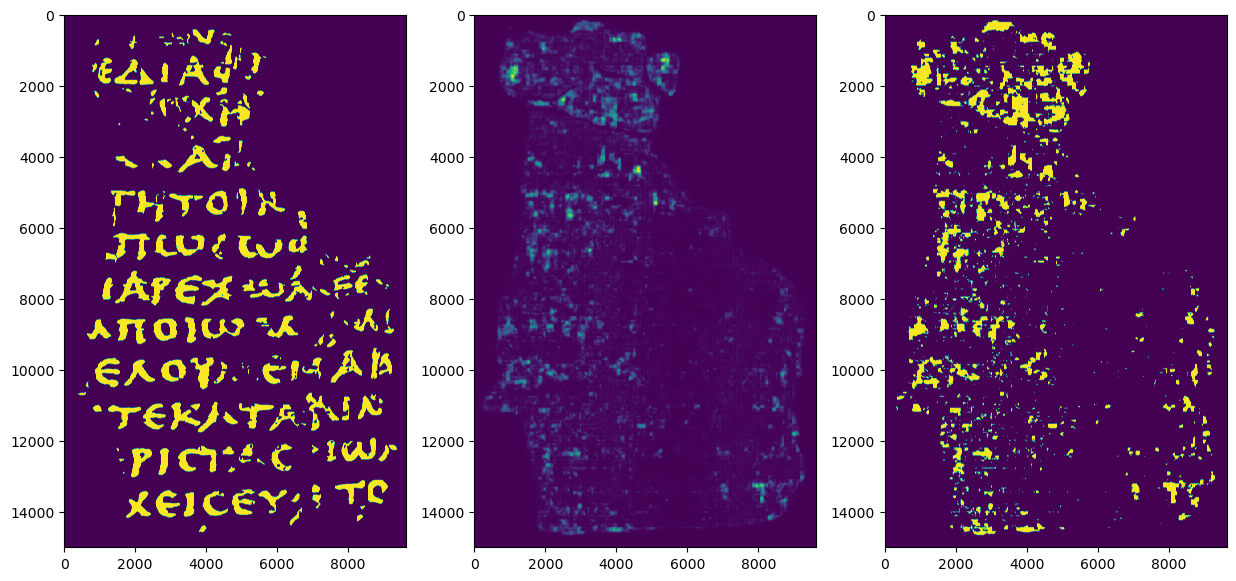

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.24877193e+08, 8.73169500e+06, 3.83546600e+06, 2.21579500e+06,
        1.48370600e+06, 1.03602500e+06, 6.83327000e+05, 4.60981000e+05,
        3.65841000e+05, 2.78678000e+05, 2.12485000e+05, 1.29592000e+05,
        7.74210000e+04, 5.61150000e+04, 4.50370000e+04, 2.97050000e+04,
        1.41140000e+04, 1.13270000e+04, 1.03000000e+04, 2.25300000e+03]),
 array([4.38277450e-04, 4.56005221e-02, 9.07627668e-02, 1.35925011e-01,
        1.81087256e-01, 2.26249501e-01, 2.71411745e-01, 3.16573990e-01,
        3.61736235e-01, 4.06898479e-01, 4.52060724e-01, 4.97222969e-01,
        5.42385213e-01, 5.87547458e-01, 6.32709703e-01, 6.77871947e-01,
        7.23034192e-01, 7.68196437e-01, 8.13358681e-01, 8.58520926e-01,
        9.03683171e-01]),
 <BarContainer object of 20 artists>)

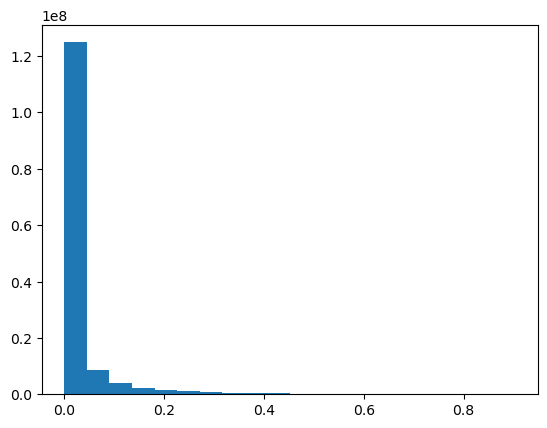

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000